In [11]:
from thresholdExtractionPranav import ThresholdExtraction
import matplotlib.pyplot as plt
import numpy as np

In [12]:
import sys
sys.argv = ['tx', '-n', 'thresh_cross_4', '-i', '192.168.30.6', '-p', '27263']

params = {'log': 'INFO',
 'pack_per_call': 1,
 'thresh_mult': -4.5,
 'thresh_calc_len': 2000,
 'butter_lowercut': 250,
 'butter_uppercut': None,
 'butter_order': 4,
 'enable_CAR': False,
 'output_filtered': False,
 'acausal_filter_lag': 120,
 'acausal_filter': 'IIR',
 'input_name': 'reref_neural',
 'input_chan_per_stream': 256,
 'input_samp_per_stream': 30,
 'input_samp_freq': 30000,
 'input_data_type': 'float32',
 'use_tracking_id': True,
 'timestamp_data_type': 'uint64',
 'sync_key': 'sync',
 'time_key': 'ts',
 'sync_source_id': 'nsp_idx_1',
 'thresholds_stream': 'thresholds',
 'neural_ch_range': [0, 96],
 'thresholds_ch_range': [0, 96],
 'n_channels': 96,
 'ch_mask_stream': 'z_mask_stream'}

node = ThresholdExtraction(params)

[thresh_cross_4] INFO: Loading 4 order, 250 hz highpass acausal IIR-IIR filter
[thresh_cross_4] INFO: Loaded thresholds from the thresholds stream


[thresh_cross_4] Redis connection established on host: 192.168.30.6, port: 27263


In [13]:
node.run()


Timing Statistics (in milliseconds):
--------------------------------------------------------------------------------
Operation                            Mean        Min        Max      Count
--------------------------------------------------------------------------------
INIT                                1.682      1.682      1.682          1
INIT time                           0.105      0.105      0.105          1
Redis read                          0.769      0.048      3.278      46357
Data parsing                        0.012      0.008      0.327      46357
Filtering                           0.133      0.112      0.529      46356
Buffer updates                      0.001      0.001      0.276      46356
Threshold detection                 0.024      0.017      0.366      46352
Redis pipeline                      0.059      0.041      0.478      46352
Threshold Extraction                0.999      0.236      3.891      46352
Threshold Extraction2               1.000      0.2

KeyboardInterrupt: 

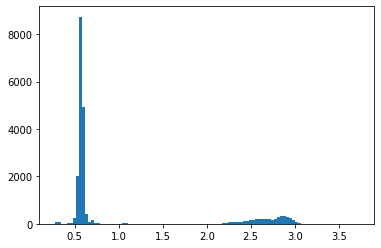

In [4]:


_=plt.hist(np.array(node.profiler.timings["Threshold Extraction3"])*1000,100)

In [10]:
import time

start = time.perf_counter()
time.sleep(0.004)  # This is more precise than other sleep methods
elapsed = time.perf_counter() - start
print(f"Elapsed time: {elapsed:.6f} seconds")

Elapsed time: 0.004270 seconds


In [35]:
import numpy as  np 

256*150
tes = np.arange(0, 150)
test = np.tile(tes[:,None],256).T

In [49]:
chunk_size = 30
sample_number = 1
start_idx = -chunk_size * sample_number
end_idx = None if sample_number == 1 else -chunk_size * (sample_number - 1)
test[:, start_idx:end_idx].shape

(256, 30)

In [59]:
import numpy as np
from numba import jit, njit, float64, boolean, int64, prange
import time

@jit(float64[:,:](
    float64[:,:], float64[:], float64[:,:], 
    int64, int64, boolean, float64

)  , parallel=True)
# 1. Numpy Vectorization Version
def calculate_thresholds_numpy(filt_buffer, mean_squared_last, mean_squared_buffer, 
                             mean_squared_buffer_index, rms_window_len,
                             mean_squared_buffer_full, thresh_mult):
    """Numpy vectorized version"""
    mean_squared_new = np.mean(filt_buffer**2, axis=1)
    
    mean_squared_last += (mean_squared_new - 
                         mean_squared_buffer[:,mean_squared_buffer_index]) / rms_window_len
    mean_squared_buffer[:,mean_squared_buffer_index] = mean_squared_new
    
    root_mean_squared = np.sqrt(mean_squared_last)
    
    if mean_squared_buffer_full:
        return (thresh_mult * root_mean_squared).reshape(-1,1)
    return np.zeros((filt_buffer.shape[0], 1))

# 2. Numba Regular Loops Version
@jit(float64[:,:](
    float64[:,:], float64[:], float64[:,:], 
    int64, int64, boolean, float64
),nopython=True)
def calculate_thresholds_numba(filt_buffer, mean_squared_last, mean_squared_buffer, 
                             mean_squared_buffer_index, rms_window_len,
                             mean_squared_buffer_full, thresh_mult):
    """Numba with regular loops"""
    num_channels = filt_buffer.shape[0]
    mean_squared_new = np.zeros(num_channels)
    
    # Calculate mean squared for each channel
    for i in range(num_channels):
        sum_squared = 0.0
        for j in range(filt_buffer.shape[1]):
            sum_squared += filt_buffer[i,j] * filt_buffer[i,j]
        mean_squared_new[i] = sum_squared / filt_buffer.shape[1]
    
    # Update mean squared last
    for i in range(num_channels):
        mean_squared_last[i] += (mean_squared_new[i] - 
                               mean_squared_buffer[i,mean_squared_buffer_index]) / rms_window_len
        mean_squared_buffer[i,mean_squared_buffer_index] = mean_squared_new[i]
    
    # Calculate thresholds
    thresholds = np.zeros((num_channels, 1))
    if mean_squared_buffer_full:
        for i in range(num_channels):
            thresholds[i,0] = thresh_mult * np.sqrt(mean_squared_last[i])
            
    return thresholds

# 3. Numba Parallel Version
@njit(float64[:,:](
    float64[:,:], float64[:], float64[:,:], 
    int64, int64, boolean, float64
),nopython=True)
def calculate_thresholds_parallel(filt_buffer, mean_squared_last, mean_squared_buffer, 
                                mean_squared_buffer_index, rms_window_len,
                                mean_squared_buffer_full, thresh_mult):
    """Numba with parallel processing"""
    num_channels = filt_buffer.shape[0]
    mean_squared_new = np.zeros(num_channels)
    
    # Calculate mean squared for each channel in parallel
    for i in prange(num_channels):
        sum_squared = 0.0
        for j in range(filt_buffer.shape[1]):
            sum_squared += filt_buffer[i,j] * filt_buffer[i,j]
        mean_squared_new[i] = sum_squared / filt_buffer.shape[1]
    
    # Update mean squared last in parallel
    for i in prange(num_channels):
        mean_squared_last[i] += (mean_squared_new[i] - 
                               mean_squared_buffer[i,mean_squared_buffer_index]) / rms_window_len
        mean_squared_buffer[i,mean_squared_buffer_index] = mean_squared_new[i]
    
    # Calculate thresholds
    thresholds = np.zeros((num_channels, 1))
    if mean_squared_buffer_full:
        for i in prange(num_channels):
            thresholds[i,0] = thresh_mult * np.sqrt(mean_squared_last[i])
            
    return thresholds

# Benchmark function
def benchmark_implementations(num_channels=64, buffer_size=1000, num_iterations=1000):
    """
    Benchmark the different implementations
    """
    # Setup test data
    filt_buffer = np.random.randn(num_channels, buffer_size)
    mean_squared_last = np.zeros(num_channels)
    mean_squared_buffer = np.zeros((num_channels, buffer_size))
    mean_squared_buffer_index = 0
    rms_window_len = buffer_size
    mean_squared_buffer_full = True
    thresh_mult = 2.0
    
    # # Warm up JIT
    # for _ in range(10):
    #     calculate_thresholds_numba(filt_buffer.copy(), mean_squared_last.copy(), 
    #                              mean_squared_buffer.copy(), mean_squared_buffer_index,
    #                              rms_window_len, mean_squared_buffer_full, thresh_mult)
    #     calculate_thresholds_parallel(filt_buffer.copy(), mean_squared_last.copy(), 
    #                                 mean_squared_buffer.copy(), mean_squared_buffer_index,
    #                                 rms_window_len, mean_squared_buffer_full, thresh_mult)
    
    # Benchmark each implementation
    results = {}
    
    # Numpy vectorized
    start = time.time()
    for _ in range(num_iterations):
        calculate_thresholds_numpy(filt_buffer, mean_squared_last, 
                                 mean_squared_buffer, mean_squared_buffer_index,
                                 rms_window_len, mean_squared_buffer_full, thresh_mult)
    results['numpy'] = (time.time() - start) / num_iterations
    filt_buffer = np.random.randn(num_channels, buffer_size)
    mean_squared_last = np.zeros(num_channels)
    mean_squared_buffer = np.zeros((num_channels, buffer_size))
    mean_squared_buffer_index = 0
    rms_window_len = buffer_size
    mean_squared_buffer_full = True
    thresh_mult = 2.0
    
    # Numba loops
    start = time.time()
    for _ in range(num_iterations):
        calculate_thresholds_numba(filt_buffer, mean_squared_last, 
                                 mean_squared_buffer, mean_squared_buffer_index,
                                 rms_window_len, mean_squared_buffer_full, thresh_mult)
    results['numba'] = (time.time() - start) / num_iterations
    filt_buffer = np.random.randn(num_channels, buffer_size)
    mean_squared_last = np.zeros(num_channels)
    mean_squared_buffer = np.zeros((num_channels, buffer_size))
    mean_squared_buffer_index = 0
    rms_window_len = buffer_size
    mean_squared_buffer_full = True
    thresh_mult = 2.0
    
    # Numba parallel
    start = time.time()
    for _ in range(num_iterations):
        calculate_thresholds_parallel(filt_buffer, mean_squared_last, 
                                    mean_squared_buffer, mean_squared_buffer_index,
                                    rms_window_len, mean_squared_buffer_full, thresh_mult)
    results['numba_parallel'] = (time.time() - start) / num_iterations
    
    return results

/tmp/ipykernel_52940/3062683339.py:5: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(float64[:,:](
/tmp/ipykernel_52940/3062683339.py:5: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "calculate_thresholds_numpy" failed type inference due to: No implementation of function Function(<function mean at 0x7f49649105e0>) found for signature:
 
 >>> mean(array(float64, 2d, C), axis=Literal[int](1))
 
There are 2 candidate implementations:
      - Of which 2 did not match due to:
      Overload in function 'array_mean': File: numba/np/arraymath.py: Line 425.
        With argument(s): '(array(float64, 2d, C), axis=int64)':
   

In [60]:
results = benchmark_implementations(num_channels=256, buffer_size=30)
for impl, times in results.items():
    print(f"{impl}: {times*1000} ms per iteration")

numpy: 0.031491756439208984 ms per iteration
numba: 0.0039942264556884766 ms per iteration
numba_parallel: 0.0033864974975585938 ms per iteration


In [38]:
results = benchmark_implementations(num_channels=256, buffer_size=30)
for impl, times in results.items():
    print(f"{impl}: {times*1000} ms per iteration")

numpy: 0.0330355167388916 ms per iteration
numba: 0.007925033569335938 ms per iteration
numba_parallel: 0.00760197639465332 ms per iteration


In [61]:
import numpy as np
from scipy import stats

def run_statistical_benchmark(num_channels=256, buffer_size=30, num_trials=30, num_iterations=1000):
    """
    Run multiple trials of benchmarking and compute statistics
    
    Parameters:
    -----------
    num_channels : int
        Number of channels in the data
    buffer_size : int
        Size of the buffer
    num_trials : int
        Number of times to repeat the entire benchmark
    num_iterations : int
        Number of iterations per trial
        
    Returns:
    --------
    dict : Statistics for each implementation
    """
    # Store results for each trial
    results = {
        'numpy': [],
        'numba': [],
        'numba_parallel': []
    }
    
    # Run multiple trials
    for trial in range(num_trials):
        trial_results = benchmark_implementations(
            num_channels=num_channels, 
            buffer_size=buffer_size,
            num_iterations=num_iterations
        )
        
        for impl in results:
            results[impl].append(trial_results[impl] * 1000)  # Convert to ms
            
    # Calculate statistics
    stats_results = {}
    for impl, times in results.items():
        times = np.array(times)
        stats_results[impl] = {
            'mean': np.mean(times),
            'std': np.std(times),
            'median': np.median(times),
            'min': np.min(times),
            'max': np.max(times),
            'ci_95': stats.t.interval(
                0.95, 
                len(times)-1, 
                loc=np.mean(times), 
                scale=stats.sem(times)
            )
        }
        
    return stats_results

# Run the statistical benchmark
stats_results = run_statistical_benchmark(
    num_channels=256, 
    buffer_size=30, 
    num_trials=30,
    num_iterations=1000
)

# Print formatted results
print("\nBenchmark Results (milliseconds per iteration):")
print("-" * 60)
for impl, stats_dict in stats_results.items():
    print(f"\n{impl.upper()}:")
    print(f"  Mean ± Std: {stats_dict['mean']} ± {stats_dict['std']}")
    print(f"  Median: {stats_dict['median']:.3f}")
    print(f"  Range: [{stats_dict['min']:.3f}, {stats_dict['max']:.3f}]")
    print(f"  95% CI: [{stats_dict['ci_95'][0]:.3f}, {stats_dict['ci_95'][1]:.3f}]")

# Calculate relative performance
baseline = stats_results['numpy']['mean']
print("\nRelative Performance (normalized to NumPy):")
print("-" * 60)
for impl, stats_dict in stats_results.items():
    relative = baseline / stats_dict['mean']
    print(f"{impl}: {relative:}x")


Benchmark Results (milliseconds per iteration):
------------------------------------------------------------

NUMPY:
  Mean ± Std: 0.019634715716044106 ± 0.0033634439995287027
  Median: 0.018
  Range: [0.016, 0.034]
  95% CI: [0.018, 0.021]

NUMBA:
  Mean ± Std: 0.0036502917607625323 ± 0.0003902041806947258
  Median: 0.004
  Range: [0.003, 0.005]
  95% CI: [0.004, 0.004]

NUMBA_PARALLEL:
  Mean ± Std: 0.0035590648651123045 ± 0.0004785038169194909
  Median: 0.003
  Range: [0.003, 0.005]
  95% CI: [0.003, 0.004]

Relative Performance (normalized to NumPy):
------------------------------------------------------------
numpy: 1.0x
numba: 5.378944205803014x
numba_parallel: 5.516818731940853x


In [74]:
import numpy as np
from numba import jit, prange, boolean, int16, float64
import time

# 4. Hybrid Version (Numba with some vectorization)
@njit()
def detect_crossings_numpy(filt_buffer, thresholds):
    """Numba parallel version of threshold crossing detection"""
    num_channels, buffer_size = filt_buffer.shape
    cross_now = np.zeros(num_channels, dtype=np.int16)
    
    for i in prange(num_channels):
        threshold = thresholds[i, 0]
        for j in range(1, buffer_size):
            if filt_buffer[i, j] < threshold and filt_buffer[i, j-1] >= threshold:
                cross_now[i] = 1
                break
    
    return cross_now

# 2. Numba Regular Loops Version
@jit(int16[:](float64[:,:], float64[:,:]))
def detect_crossings_numba(filt_buffer, thresholds):
    """Numba optimized version with regular loops"""

    num_channels, buffer_size = filt_buffer.shape
    cross_now = np.zeros(num_channels, dtype=np.int16)
    
    for i in range(num_channels):
        threshold = thresholds[i, 0]
        for j in range(1, buffer_size):
            if filt_buffer[i, j] < threshold and filt_buffer[i, j-1] >= threshold:
                cross_now[i] = 1
                break
    
    return cross_now

# 3. Numba Parallel Version
@jit(int16[:](float64[:,:], float64[:,:]), parallel=True)
def detect_crossings_parallel(filt_buffer, thresholds):
    """Numba parallel version of threshold crossing detection"""
    num_channels, buffer_size = filt_buffer.shape
    cross_now = np.zeros(num_channels, dtype=np.int16)
    
    for i in prange(num_channels):
        threshold = thresholds[i, 0]
        for j in range(1, buffer_size):
            if filt_buffer[i, j] < threshold and filt_buffer[i, j-1] >= threshold:
                cross_now[i] = 1
                break
    
    return cross_now

# 4. Hybrid Version (Numba with some vectorization)
@njit(int16[:](float64[:,:], float64[:,:]))
def detect_crossings_hybrid(filt_buffer, thresholds):
    """Numba parallel version of threshold crossing detection"""
    num_channels, buffer_size = filt_buffer.shape
    cross_now = np.zeros(num_channels, dtype=np.int16)
    
    for i in prange(num_channels):
        threshold = thresholds[i, 0]
        for j in range(1, buffer_size):
            if filt_buffer[i, j] < threshold and filt_buffer[i, j-1] >= threshold:
                cross_now[i] = 1
                break
    
    return cross_now

def benchmark_crossing_implementations(num_channels=256, buffer_size=30, num_trials=30, num_iterations=1000):
    """
    Benchmark different implementations of threshold crossing detection
    """
    # Setup test data
    filt_buffer = np.random.randn(num_channels, buffer_size)
    thresholds = np.random.randn(num_channels, 1) * 0.5
    
    # Initialize results dictionary
    results = {
        'numpy': [],
        'numba': [],
        'numba_parallel': [],
        'hybrid': []
    }
    
    # Warm up JIT
    # for _ in range(10):
    #     detect_crossings_numba(filt_buffer, thresholds)
    #     detect_crossings_parallel(filt_buffer, thresholds)
    #     detect_crossings_hybrid(filt_buffer, thresholds)
    
    # Run trials
    for trial in range(num_trials):
        # Numpy version
        start = time.time()
        for _ in range(num_iterations):
            detect_crossings_numpy(filt_buffer, thresholds)
        results['numpy'].append((time.time() - start) * 1000 / num_iterations)
        
        # Numba version
        start = time.time()
        for _ in range(num_iterations):
            detect_crossings_numba(filt_buffer, thresholds)
        results['numba'].append((time.time() - start) * 1000 / num_iterations)
        
        # Parallel version
        start = time.time()
        for _ in range(num_iterations):
            detect_crossings_parallel(filt_buffer, thresholds)
        results['numba_parallel'].append((time.time() - start) * 1000 / num_iterations)
        
        # Hybrid version
        start = time.time()
        for _ in range(num_iterations):
            detect_crossings_hybrid(filt_buffer, thresholds)
        results['hybrid'].append((time.time() - start) * 1000 / num_iterations)
    
    # Calculate statistics
    stats_results = {}
    for impl, times in results.items():
        times = np.array(times)
        stats_results[impl] = {
            'mean': np.mean(times),
            'std': np.std(times),
            'median': np.median(times),
            'min': np.min(times),
            'max': np.max(times),
            'ci_95': stats.t.interval(
                0.95, 
                len(times)-1, 
                loc=np.mean(times), 
                scale=stats.sem(times)
            )
        }
        
    return stats_results

# Run benchmark
stats_results = benchmark_crossing_implementations(
    num_channels=256,
    buffer_size=30,
    num_trials=30,
    num_iterations=1000
)

# Print results
print("\nCrossing Detection Benchmark Results (milliseconds per iteration):")
print("-" * 70)
for impl, stats_dict in stats_results.items():
    print(f"\n{impl.upper()}:")
    print(f"  Mean ± Std: {stats_dict['mean']} ± {stats_dict['std']}")
    print(f"  Median: {stats_dict['median']:.3f}")
    print(f"  Range: [{stats_dict['min']:.3f}, {stats_dict['max']:.3f}]")
    print(f"  95% CI: [{stats_dict['ci_95'][0]:.3f}, {stats_dict['ci_95'][1]:.3f}]")

# Calculate relative performance
baseline = stats_results['numpy']['mean']
print("\nRelative Performance (normalized to NumPy):")
print("-" * 70)
for impl, stats_dict in stats_results.items():
    relative = baseline / stats_dict['mean']
    print(f"{impl}: {relative}x")

/tmp/ipykernel_52940/1551340056.py:22: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(int16[:](float64[:,:], float64[:,:]))
/tmp/ipykernel_52940/1551340056.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(int16[:](float64[:,:], float64[:,:]), parallel=True)



Crossing Detection Benchmark Results (milliseconds per iteration):
----------------------------------------------------------------------

NUMPY:
  Mean ± Std: 0.006376727422078451 ± 0.02106855036982988
  Median: 0.003
  Range: [0.002, 0.120]
  95% CI: [-0.002, 0.014]

NUMBA:
  Mean ± Std: 0.002399897575378418 ± 0.0007850833120321406
  Median: 0.002
  Range: [0.001, 0.005]
  95% CI: [0.002, 0.003]

NUMBA_PARALLEL:
  Mean ± Std: 0.019684775670369466 ± 0.033935952585662774
  Median: 0.008
  Range: [0.004, 0.166]
  95% CI: [0.007, 0.033]

HYBRID:
  Mean ± Std: 0.0024316151936848956 ± 0.0007238741228969975
  Median: 0.003
  Range: [0.002, 0.005]
  95% CI: [0.002, 0.003]

Relative Performance (normalized to NumPy):
----------------------------------------------------------------------
numpy: 1.0x
numba: 2.6570831553396452x
numba_parallel: 0.3239420925521152x
hybrid: 2.6224245672750093x


In [104]:
import numpy as np
from numba import jit, prange, float64, boolean
import time
import numpy as np
from scipy import stats
# 1. Numpy Vectorized Version
def calculate_power_numpy(filt_buffer, logscale=False):
    """Numpy vectorized version of power calculation"""
    if logscale:
        return 10 * np.log10(np.square(filt_buffer).mean(axis=1))
    return np.square(filt_buffer).mean(axis=1)

# 2. Numba Regular Loops Version
@jit(float64[:](float64[:,:], boolean))
def calculate_power_numba(filt_buffer, logscale):
    """Numba optimized version with regular loops"""
    num_channels, buffer_size = filt_buffer.shape
    power = np.zeros(num_channels)
    
    for i in range(num_channels):
        sum_squared = 0.0
        for j in range(buffer_size):
            sum_squared += filt_buffer[i,j] * filt_buffer[i,j]
        
        mean_power = sum_squared / buffer_size
        if logscale:
            power[i] = 10 * np.log10(mean_power)
        else:
            power[i] = mean_power
            
    return power

# 3. Numba Parallel Version
@jit
def calculate_power_parallel(filt_buffer, logscale):
    """Numba parallel version of power calculation"""
    num_channels, buffer_size = filt_buffer.shape
    power = np.zeros(num_channels)
    
    for i in prange(num_channels):
        sum_squared = 0.0
        for j in range(buffer_size):
            sum_squared += filt_buffer[i,j] * filt_buffer[i,j]
            
        mean_power = sum_squared / buffer_size
        if logscale:
            power[i] = 10 * np.log10(mean_power)
        else:
            power[i] = mean_power
            
    return power

# 4. Hybrid Version (Numba with partial vectorization)
@jit(float64[:](float64[:,:], boolean))
def calculate_power_hybrid(filt_buffer, logscale):
    """Hybrid approach using both Numba and some vectorization"""
    num_channels = filt_buffer.shape[0]
    power = np.zeros(num_channels)
    
    # Use vectorized operations along buffer axis
    squared = filt_buffer * filt_buffer
    mean_power = np.mean(squared, axis=1)
    
    if logscale:
        for i in range(num_channels):
            power[i] = 10 * np.log10(mean_power[i])
    else:
        power[:] = mean_power
        
    return power

def benchmark_power_implementations(num_channels=256, buffer_size=30, num_trials=30, 
                                 num_iterations=1000, logscale=True):
    """
    Benchmark different implementations of band power calculation
    """
    # Setup test data
    filt_buffer = np.random.randn(num_channels, buffer_size)
    
    # Initialize results dictionary
    results = {
        'numpy': [],
        'numba': [],
        'numba_parallel': [],
        'hybrid': []
    }
    
    # Warm up JIT
    # for _ in range(10):
    #     calculate_power_numba(filt_buffer, logscale)
    #     calculate_power_parallel(filt_buffer, logscale)
    #     calculate_power_hybrid(filt_buffer, logscale)
    
    # Run trials
    for trial in range(num_trials):
        # Numpy version
        start = time.time()
        for _ in range(num_iterations):
            calculate_power_numpy(filt_buffer, logscale)
        results['numpy'].append((time.time() - start) * 1000 / num_iterations)
        
        # Numba version
        start = time.time()
        for _ in range(num_iterations):
            calculate_power_numba(filt_buffer, logscale)
        results['numba'].append((time.time() - start) * 1000 / num_iterations)
        
        # Parallel version
        start = time.time()
        for _ in range(num_iterations):
            calculate_power_parallel(filt_buffer, logscale)
        results['numba_parallel'].append((time.time() - start) * 1000 / num_iterations)
        
        # Hybrid version
        start = time.time()
        for _ in range(num_iterations):
            calculate_power_hybrid(filt_buffer, logscale)
        results['hybrid'].append((time.time() - start) * 1000 / num_iterations)
    
    # Calculate statistics
    stats_results = {}
    for impl, times in results.items():
        times = np.array(times)
        stats_results[impl] = {
            'mean': np.mean(times),
            'std': np.std(times),
            'median': np.median(times),
            'min': np.min(times),
            'max': np.max(times),
            'ci_95': stats.t.interval(
                0.95, 
                len(times)-1, 
                loc=np.mean(times), 
                scale=stats.sem(times)
            ) if len(times) > 1 else (np.mean(times), np.mean(times))
        }
        
    return stats_results

# Function to compare numerical accuracy
def compare_accuracy(num_channels=256, buffer_size=30, logscale=True):
    """Compare numerical accuracy between implementations"""
    filt_buffer = np.random.randn(num_channels, buffer_size)
    
    # Get results from each implementation
    numpy_result = calculate_power_numpy(filt_buffer, logscale)
    numba_result = calculate_power_numba(filt_buffer, logscale)
    parallel_result = calculate_power_parallel(filt_buffer, logscale)
    hybrid_result = calculate_power_hybrid(filt_buffer, logscale)
    
    # Compare with numpy as reference
    results = {
        'numba_max_diff': np.max(np.abs(numpy_result - numba_result)),
        'parallel_max_diff': np.max(np.abs(numpy_result - parallel_result)),
        'hybrid_max_diff': np.max(np.abs(numpy_result - hybrid_result))
    }
    
    return results

# Run benchmarks for both linear and log scale
print("\nRunning benchmarks for linear scale...")
linear_stats = benchmark_power_implementations(logscale=False)
print("\nRunning benchmarks for log scale...")
log_stats = benchmark_power_implementations(logscale=True)

# Print results
for scale, stats in [("Linear Scale", linear_stats), ("Log Scale", log_stats)]:
    print(f"\n{scale} Results (milliseconds per iteration):")
    print("-" * 70)
    baseline = stats['numpy']['mean']
    for impl, stats_dict in stats.items():
        print(f"\n{impl.upper()}:")
        print(f"  Mean ± Std: {stats_dict['mean']} ± {stats_dict['std']}")
        print(f"  Median: {stats_dict['median']:.3f}")
        print(f"  Range: [{stats_dict['min']:.3f}, {stats_dict['max']:.3f}]")
        print(f"  95% CI: [{stats_dict['ci_95'][0]:.3f}, {stats_dict['ci_95'][1]:.3f}]")
        print(f"  Relative to NumPy: {baseline/stats_dict['mean']:.2f}x")

# Check numerical accuracy
accuracy_results = compare_accuracy()
print("\nNumerical Accuracy (max absolute difference from NumPy):")
print("-" * 70)
for impl, diff in accuracy_results.items():
    print(f"{impl}: {diff:.2e}")

/tmp/ipykernel_52940/570491558.py:14: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(float64[:](float64[:,:], boolean))
/tmp/ipykernel_52940/570491558.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def calculate_power_parallel(filt_buffer, logscale):
/tmp/ipykernel_52940/570491558.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not 


Running benchmarks for linear scale...

Running benchmarks for log scale...

Linear Scale Results (milliseconds per iteration):
----------------------------------------------------------------------

NUMPY:
  Mean ± Std: 0.012447079022725424 ± 0.0016272688029233932
  Median: 0.012
  Range: [0.011, 0.020]
  95% CI: [0.012, 0.013]
  Relative to NumPy: 1.00x

NUMBA:
  Mean ± Std: 0.0029752175013224285 ± 0.0006479974682155426
  Median: 0.003
  Range: [0.002, 0.006]
  95% CI: [0.003, 0.003]
  Relative to NumPy: 4.18x

NUMBA_PARALLEL:
  Mean ± Std: 0.006543270746866862 ± 0.020822918681311354
  Median: 0.003
  Range: [0.002, 0.119]
  95% CI: [-0.001, 0.014]
  Relative to NumPy: 1.90x

HYBRID:
  Mean ± Std: 0.015427438418070476 ± 0.0020421363442553525
  Median: 0.015
  Range: [0.014, 0.025]
  95% CI: [0.015, 0.016]
  Relative to NumPy: 0.81x

Log Scale Results (milliseconds per iteration):
----------------------------------------------------------------------

NUMPY:
  Mean ± Std: 0.016300058

In [106]:

@njit(int16[:](float64[:,:], float64[:]))
def get_threshold_crossing(filt_buffer, thresholds ):
    num_channels, buffer_size = filt_buffer.shape
    cross_now = np.zeros(num_channels, dtype=np.int16)
    
    for i in range(num_channels):
        threshold = thresholds[i]
        for j in range(1, buffer_size):
            if filt_buffer[i, j] < threshold and filt_buffer[i, j-1] >= threshold:
                cross_now[i] = 1
                break
    
    return cross_now



@njit(float64[:](float64[:,:], float64[:], boolean))
def get_spike_bandpower(filt_buffer, power_buffer, logscale=False):
    num_channels, buffer_size = filt_buffer.shape
    
    for i in range(num_channels):
        sum_squared = 0.0
        for j in range(buffer_size):
            if logscale:
                sum_squared += 10* np.log10(filt_buffer[i,j] * filt_buffer[i,j])
            else:
                sum_squared += filt_buffer[i,j] * filt_buffer[i,j]
        
        mean_power = sum_squared / buffer_size
        power_buffer[i] = mean_power
    return power_buffer

In [96]:

@njit(int64[:](float64[:,:], float64[:,:]))
def get_spike_bandpower(filt_buffer, power_buffer):
    # num_channels, buffer_size = filt_buffer.shape
    num_channels, buffer_size=256,30
    # logscale=False
    for i in range(num_channels):
        sum_squared = 0.0
        for j in range(buffer_size):

            sum_squared += filt_buffer[i,j] * filt_buffer[i,j]
        
        mean_power = sum_squared 
        power_buffer[i] = mean_power
    return power_buffer.copy()

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
No conversion from array(float64, 2d, C) to array(int64, 1d, A) for '$88return_value.3', defined at None

File "../../../../../../../../tmp/ipykernel_52940/1606340820.py", line 14:
<source missing, REPL/exec in use?>

During: typing of assignment at /tmp/ipykernel_52940/1606340820.py (14)

File "../../../../../../../../tmp/ipykernel_52940/1606340820.py", line 14:
<source missing, REPL/exec in use?>
